In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV

In [56]:
!mkdir -p ~/.kaggle  # Create the directory if not exists
!mv kaggle.json ~/.kaggle/  # Move the API key to the correct location
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

# Download the dataset
!kaggle datasets download -d datasetengineer/logistics-and-supply-chain-dataset --unzip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datasetengineer/logistics-and-supply-chain-dataset
License(s): CC0-1.0
  0% 0.00/6.89M [00:00<?, ?B/s]
100% 6.89M/6.89M [00:00<00:00, 90.5MB/s]


In [57]:
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
df.drop(columns=['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'], inplace=True)
df.head()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [58]:
df.shape

(32065, 23)

In [59]:
# Look if there are any duplicate rows in the dataset
df.loc[df.duplicated()]

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation


In [60]:
# Check for null values
df.isna().sum()

,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0
weather_condition_severity,0
port_congestion_level,0
shipping_costs,0


In [61]:
# view summary statistics --> before remove outlier
df.describe()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,delivery_time_deviation
count,32065.000000,32065.000000,3.206500e+04,3.206500e+04,32065.000000,3.206500e+04,32065.000000,3.206500e+04,32065.000000,32065.000000,...,32065.000000,32065.000000,3.206500e+04,32065.000000,32065.000000,3.206500e+04,3.206500e+04,32065.000000,32065.000000,32065.000000
mean,8.011735,2.893068,4.991493e+00,2.992547e+02,2.291669,3.026954e-01,0.600740,4.976082e-01,6.978414,459.374452,...,6022.001286,0.044792,2.972816e-01,7.001144,2.296448,4.983913e-01,6.008723e-01,0.803656,0.699077,5.177648
std,4.264960,2.274044,3.532048e+00,3.234435e+02,1.554202,3.259146e-01,0.345672,3.532853e-01,3.251051,312.183487,...,3427.638017,14.187486,3.216115e-01,3.236328,1.555932,3.541589e-01,3.458101e-01,0.279185,0.324514,4.157988
min,5.000000,-1.999993,1.091633e-09,1.322210e-12,0.500000,4.565769e-16,0.000001,4.536949e-09,0.000002,100.000000,...,100.002966,-10.000000,7.255415e-19,0.000050,0.500000,4.043927e-09,3.269508e-07,0.000048,0.000003,-1.999998
25%,5.019984,1.185744,1.474720e+00,1.605163e+01,0.774798,1.710828e-02,0.277096,1.440135e-01,4.513889,154.017124,...,2822.607616,-9.931074,1.678269e-02,4.593407,0.776166,1.443567e-01,2.783148e-01,0.693739,0.456009,1.269197
50%,5.636036,3.882059,4.981244e+00,1.572880e+02,1.917121,1.595151e-01,0.680553,4.961781e-01,8.383225,388.996911,...,6785.123209,-7.858681,1.549760e-01,8.385605,1.938273,4.988468e-01,6.831130e-01,0.958128,0.839599,6.113662
75%,9.669944,4.884355,8.534902e+00,5.405980e+02,3.734188,5.535954e-01,0.938160,8.498226e-01,9.838150,753.007203,...,9374.252913,6.024012,5.405408e-01,9.836152,3.750817,8.510762e-01,9.372889e-01,0.998746,0.982391,9.249206
max,19.999875,5.000000,9.999999e+00,9.999993e+02,5.000000,9.999995e-01,1.000000,1.000000e+00,10.000000,999.999853,...,10000.000000,39.999886,1.000000e+00,10.000000,5.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,10.000000


In [62]:
# check varince --> before remove outlier
df.drop(columns='risk_classification').var().sort_values(ascending=False)

,0
historical_demand,1.174870e+07
warehouse_inventory_level,1.046157e+05
shipping_costs,9.745853e+04
iot_temperature,2.012848e+02
lead_time_days,2.045830e+01
fuel_consumption_rate,1.818988e+01
delivery_time_deviation,1.728886e+01
traffic_congestion_level,1.247536e+01
port_congestion_level,1.056933e+01
route_risk_level,1.047382e+01


In [63]:
numerical_list = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_list)

['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score', 'delay_probability', 'delivery_time_deviation']


In [64]:
#Removal of outlier:

df1 = df.copy()

for i in numerical_list:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
# display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df = df1.copy()
df.head()


Inference:
Before removal of outliers, The dataset had 32065 samples.
After removal of outliers, The dataset now has 25245 samples.


,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [65]:
# view summary statistics --> after remove outlier
df.describe()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,delivery_time_deviation
count,25245.000000,25245.000000,2.524500e+04,2.524500e+04,25245.000000,2.524500e+04,25245.000000,2.524500e+04,25245.000000,25245.000000,...,25245.000000,25245.000000,2.524500e+04,25245.000000,25245.000000,2.524500e+04,2.524500e+04,25245.000000,25245.000000,25245.000000
mean,7.108772,2.897818,4.989033e+00,2.976430e+02,2.284563,3.035803e-01,0.600779,4.980191e-01,6.991744,458.698267,...,6030.353235,-2.727396,2.980991e-01,7.001806,2.292114,4.991364e-01,6.020849e-01,0.862198,0.699789,5.171397
std,3.072851,2.269539,3.530389e+00,3.232525e+02,1.551540,3.261634e-01,0.345864,3.537310e-01,3.247718,312.020578,...,3429.420083,10.556655,3.216070e-01,3.242380,1.557051,3.538941e-01,3.463947e-01,0.200877,0.323586,4.164164
min,5.000000,-1.999993,1.091633e-09,1.322210e-12,0.500000,4.565769e-16,0.000001,4.536949e-09,0.000002,100.000000,...,100.002966,-10.000000,7.255415e-19,0.000050,0.500000,4.748974e-08,3.814141e-07,0.237997,0.000003,-1.999998
25%,5.013478,1.205543,1.486248e+00,1.576525e+01,0.772435,1.707241e-02,0.275941,1.440135e-01,4.537795,154.042487,...,2828.374975,-9.954591,1.706098e-02,4.586396,0.770691,1.460157e-01,2.800075e-01,0.795017,0.459434,1.245645
50%,5.422352,3.880706,4.962788e+00,1.544918e+02,1.910044,1.605569e-01,0.679374,4.962405e-01,8.399673,388.099409,...,6796.655200,-8.547272,1.581432e-01,8.398631,1.925133,5.005310e-01,6.851510e-01,0.972332,0.840493,6.110061
75%,8.171268,4.885036,8.537137e+00,5.368136e+02,3.720328,5.550604e-01,0.939482,8.513973e-01,9.841271,751.813677,...,9381.260495,1.011558,5.405426e-01,9.839039,3.747872,8.520249e-01,9.391259e-01,0.999192,0.982093,9.249240
max,16.643091,5.000000,9.999999e+00,9.999993e+02,5.000000,9.999983e-01,1.000000,1.000000e+00,10.000000,999.999853,...,9999.999999,29.789586,1.000000e+00,10.000000,4.999999,1.000000e+00,1.000000e+00,1.000000,1.000000,10.000000


In [66]:
# check varince --> after remove outlier
df.drop(columns='risk_classification').var().sort_values(ascending=False)

,0
historical_demand,1.176092e+07
warehouse_inventory_level,1.044922e+05
shipping_costs,9.735684e+04
iot_temperature,1.114430e+02
lead_time_days,2.042710e+01
delivery_time_deviation,1.734026e+01
traffic_congestion_level,1.246365e+01
port_congestion_level,1.054767e+01
route_risk_level,1.051303e+01
fuel_consumption_rate,9.442411e+00


In [67]:
df['risk_classification'].value_counts()

,count
risk_classification,
High Risk,20451
Moderate Risk,4277
Low Risk,517


In [68]:
# Label encoding

label_encoder = LabelEncoder()
df['risk_classification'] = label_encoder.fit_transform(df['risk_classification'])

In [69]:
# target class are highly imbalanced
df['risk_classification'].value_counts()

,count
risk_classification,
0,20451
2,4277
1,517


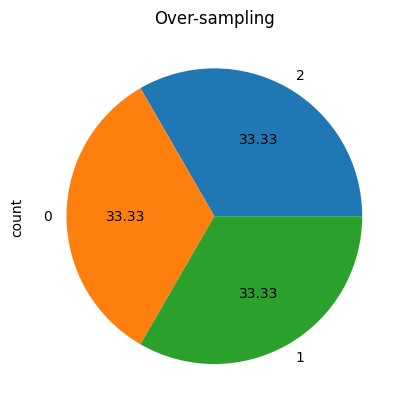

In [70]:
# solve imbalnce class

#Random Oversampling
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy="not majority") # String
# X = df.drop(['risk_classification'], axis=1)
# Y = df['risk_classification']
# X, Y = ros.fit_resample(X, Y)

# ------------------------------------------------------------

# Apply SMOTE (Synthetic Minority Over-sampling)
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["risk_classification"])  # Features
Y = df["risk_classification"]  # Target
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, Y = smote.fit_resample(X, Y)

ax = Y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [71]:
# after solve imbalnce class
Y.value_counts()

,count
risk_classification,
2,20451
0,20451
1,20451


In [72]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

# Transform data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)

[[3.02374242e-02 7.89349876e-02 9.32954160e-01 ... 9.99999905e-01
  8.60255460e-02 3.62378528e-01]
 [2.31466411e-01 2.09533993e-01 6.08026312e-01 ... 4.25159648e-01
  9.90943952e-01 8.97401831e-01]
 [6.26034147e-01 8.46086129e-01 9.93038106e-01 ... 7.06908586e-01
  1.85222184e-01 9.85688425e-01]
 ...
 [7.06113618e-04 9.45098327e-01 7.77323937e-01 ... 9.39471100e-01
  4.66093470e-01 4.49122598e-01]
 [1.42111363e-01 9.98444673e-01 3.26975161e-02 ... 9.99954095e-01
  9.44649922e-01 9.25596302e-01]
 [1.89266617e-02 3.25377538e-01 7.40088698e-01 ... 1.44876671e-01
  9.98679425e-01 6.70389907e-01]]


In [77]:
# test with random forrest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  0.9999348067018711
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5011
           1       1.00      1.00      1.00      5181
           2       1.00      1.00      1.00      5147

    accuracy                           1.00     15339
   macro avg       1.00      1.00      1.00     15339
weighted avg       1.00      1.00      1.00     15339

Confusion Matrix: 
[[5011    0    0]
 [   0 5181    0]
 [   0    1 5146]]


In [76]:
# test with decision tree
from sklearn.tree import DecisionTreeClassifier

model =  DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5011
           1       1.00      1.00      1.00      5181
           2       1.00      1.00      1.00      5147

    accuracy                           1.00     15339
   macro avg       1.00      1.00      1.00     15339
weighted avg       1.00      1.00      1.00     15339

Confusion Matrix: 
[[5011    0    0]
 [   0 5181    0]
 [   0    0 5147]]


In [79]:
# test with SVM
from sklearn.svm import SVC

# model =  SVC(kernel='linear', random_state=42)
model = SVC(kernel = 'rbf', gamma = 1 , C = 100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  0.9959580155160049
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5011
           1       1.00      1.00      1.00      5181
           2       0.99      1.00      0.99      5147

    accuracy                           1.00     15339
   macro avg       1.00      1.00      1.00     15339
weighted avg       1.00      1.00      1.00     15339

Confusion Matrix: 
[[4966    0   45]
 [   0 5181    0]
 [  12    5 5130]]


In [82]:
# test with Logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  0.9885911728274334
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5011
           1       0.98      1.00      0.99      5181
           2       0.99      0.98      0.98      5147

    accuracy                           0.99     15339
   macro avg       0.99      0.99      0.99     15339
weighted avg       0.99      0.99      0.99     15339

Confusion Matrix: 
[[4945    0   66]
 [   0 5181    0]
 [   0  109 5038]]


In [85]:
# test with Single layer perceptron
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(), max_iter=1000, random_state=42)  # No hidden layers
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  0.9917204511376231
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5011
           1       0.99      1.00      0.99      5181
           2       0.99      0.99      0.99      5147

    accuracy                           0.99     15339
   macro avg       0.99      0.99      0.99     15339
weighted avg       0.99      0.99      0.99     15339

Confusion Matrix: 
[[4956    0   55]
 [   0 5181    0]
 [   0   72 5075]]


In [86]:
# test with Multiple layer perceptron
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # 1 hidden layer
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Confusion Matrix and Evalution matrix

print('Accuracy is: ',accuracy_score(y_test, y_pred ))
print(classification_report(y_test, y_pred ))
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix: ")
print(cm)

Accuracy is:  0.9983049742486473
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5011
           1       1.00      1.00      1.00      5181
           2       1.00      1.00      1.00      5147

    accuracy                           1.00     15339
   macro avg       1.00      1.00      1.00     15339
weighted avg       1.00      1.00      1.00     15339

Confusion Matrix: 
[[5001    0   10]
 [   0 5181    0]
 [  11    5 5131]]
